In [1]:
import pandas as pd
import numpy as np
from scipy.stats import beta
import random
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
from datetime import datetime

In [4]:
orders = pd.read_csv(r"olist_orders_dataset.csv")
order_items = pd.read_csv(r"olist_order_items_dataset.csv")
products = pd.read_csv(r"olist_products_dataset.csv")
reviews = pd.read_csv(r"olist_order_reviews_dataset.csv")
categories_translation = pd.read_csv(r"product_category_name_translation.csv")
    
    
products = products.merge(
    categories_translation, 
    on='product_category_name', 
    how='left'
)

In [5]:
def prepare_category_data(orders: pd.DataFrame, 
                         order_items: pd.DataFrame,
                         products: pd.DataFrame,
                         reviews: pd.DataFrame) -> pd.DataFrame:
    df = orders.merge(order_items, on='order_id')
    df = df.merge(products[['product_id', 'product_category_name_english']], on='product_id')
    df = df.merge(reviews[['order_id', 'review_score']], on='order_id')
    
    category_metrics = df.groupby('product_category_name_english').agg({
        'order_id': 'count',
        'review_score': ['mean', 'count'],
        'price': ['mean', 'std']
    }).round(2)
    
    category_metrics.columns = ['total_orders', 'avg_review', 'review_count', 'avg_price', 'price_std']
    return category_metrics.reset_index()

In [6]:
def initialize_bandit_metrics(categories: List[str]) -> Dict:
    
    return {
        cat: {
            'alpha': 1.0,  # Prior success
            'beta': 1.0,   # Prior failure
            'trials': 0,
            'successes': 0
        }
        for cat in categories
    }

In [7]:
def get_recommendation(bandit_metrics: Dict) -> str:
   
    samples = {
        cat: beta.rvs(metrics['alpha'], metrics['beta'])
        for cat, metrics in bandit_metrics.items()
    }
    return max(samples.items(), key=lambda x: x[1])[0]

In [8]:
def update_metrics(bandit_metrics: Dict, 
                  category: str, 
                  success: bool) -> Dict:
   
    metrics = bandit_metrics[category]
    metrics['trials'] += 1
    if success:
        metrics['alpha'] += 1
        metrics['successes'] += 1
    else:
        metrics['beta'] += 1
    return bandit_metrics

In [9]:
def calculate_category_success_rates(df: pd.DataFrame) -> Dict[str, float]:
   
    success_rates = {}
    for category in df['product_category_name_english'].unique():
        category_reviews = df[df['product_category_name_english'] == category]['review_score']
        success_rates[category] = (category_reviews >= 4).mean()
    return success_rates

In [10]:
def simulate_recommendations(category_data: pd.DataFrame, 
                           n_iterations: int = 1000) -> Tuple[Dict, List]:
   
    categories = category_data['product_category_name_english'].tolist()
    bandit_metrics = initialize_bandit_metrics(categories)
    
    true_rates = dict(zip(
        category_data['product_category_name_english'],
        (category_data['avg_review'] >= 4).astype(float)
    ))
    
    history = []
    
    for i in range(n_iterations):
        recommended_category = get_recommendation(bandit_metrics)
        
        success = random.random() < true_rates[recommended_category]
        
        bandit_metrics = update_metrics(bandit_metrics, recommended_category, success)
        
        if i % 50 == 0:  
            history.append({
                'iteration': i,
                'category': recommended_category,
                'success': success,
                'metrics': {
                    cat: {
                        'success_rate': m['successes'] / m['trials'] if m['trials'] > 0 else 0,
                        'trials': m['trials']
                    }
                    for cat, m in bandit_metrics.items()
                }
            })
    
    return bandit_metrics, history

In [11]:
def plot_results(history: List, category_data: pd.DataFrame):
    
    plt.figure(figsize=(15, 8))
    
    top_categories = category_data.nlargest(5, 'total_orders')['product_category_name_english']
    
    for category in top_categories:
        rates = []
        iterations = []
        
        for h in history:
            if category in h['metrics']:
                rates.append(h['metrics'][category]['success_rate'])
                iterations.append(h['iteration'])
        
        plt.plot(iterations, rates, label=category)
    
    plt.xlabel('Iteration')
    plt.ylabel('Success Rate')
    plt.title('Category Success Rates Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    return plt


Top Performing Categories:

agro_industry_and_commerce
Success Rate: 1.000
Total Trials: 4

arts_and_craftmanship
Success Rate: 1.000
Total Trials: 4

auto
Success Rate: 1.000
Total Trials: 19

baby
Success Rate: 1.000
Total Trials: 9

books_general_interest
Success Rate: 1.000
Total Trials: 36


<Figure size 864x432 with 0 Axes>

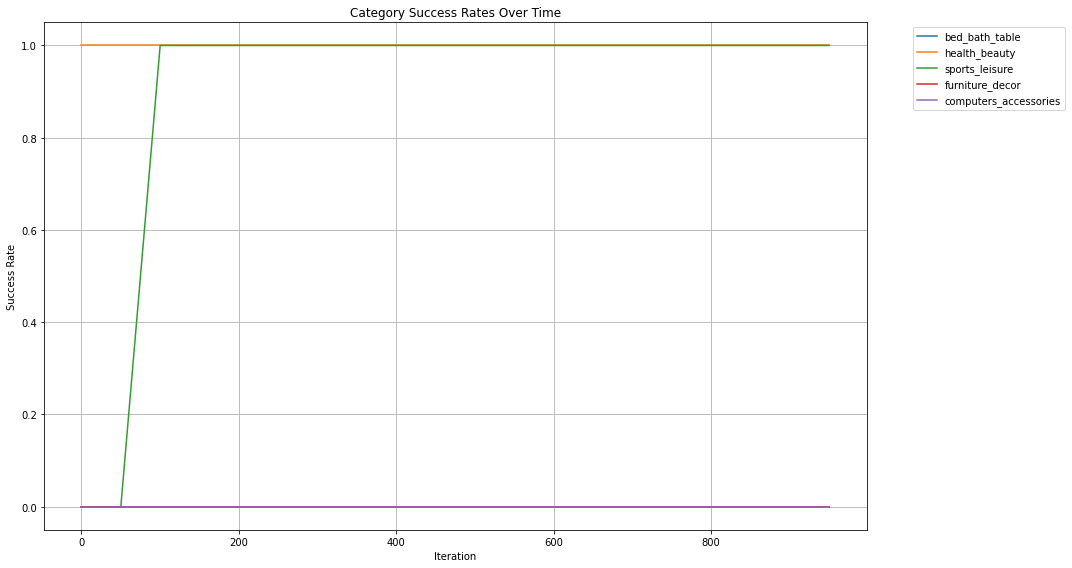

In [12]:
category_data = prepare_category_data(orders, order_items, products, reviews)

final_metrics, history = simulate_recommendations(category_data)

print("\nTop Performing Categories:")
for category, metrics in sorted(
    final_metrics.items(),
    key=lambda x: x[1]['successes'] / x[1]['trials'] if x[1]['trials'] > 0 else 0,
    reverse=True
)[:5]:
    success_rate = metrics['successes'] / metrics['trials'] if metrics['trials'] > 0 else 0
    print(f"\n{category}")
    print(f"Success Rate: {success_rate:.3f}")
    print(f"Total Trials: {metrics['trials']}")

plt.figure(figsize=(12, 6))
plot_results(history, category_data)
plt.show()